In [4]:
import read_data 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.io.pickle import to_pickle, read_pickle
save_dir = 'text_classifier1/'
import os
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
#%% first steps
books,genre,excerpt = read_data.read_text_data()
id_train,id_val = read_data.read_ids()

MAX_WORDS = 5000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(excerpt.values())
sequences = tokenizer.texts_to_sequences(excerpt.values())

word_index = tokenizer.word_index
to_pickle(tokenizer, save_dir+'text_tokenizer.pickle')
print('Found %s unique tokens.' % len(word_index))


Found 169991 unique tokens.


(0, 10000)

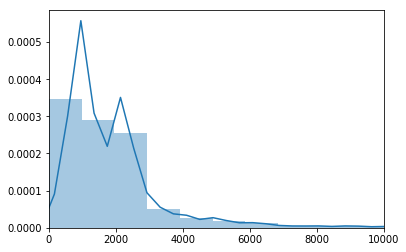

In [6]:
lens = [len(s) for s in sequences]
sns.distplot(lens)
plt.xlim((0,10000))

In [7]:
MAXLEN = 6000
data = pad_sequences(sequences, maxlen=MAXLEN)

#labels = to_categorical(np.asarray(labels))
labels = ['Fiction' in genre[id] for id in excerpt.keys()]
labels = np.array(labels).reshape((-1,1))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (4166, 6000)
Shape of label tensor: (4166, 1)


In [9]:
# split the data into a training set and a validation set

train_index = [id in id_train for id in excerpt.keys()]
val_index = [id in id_val for id in excerpt.keys()]
x_train = data[train_index]
y_train = labels[train_index]
x_val = data[val_index]
y_val = labels[val_index]
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

to_pickle((x_train, y_train, x_val, y_val),save_dir+'text_dataset.pc')

(2922, 6000) (2922, 1) (1244, 6000) (1244, 1)


In [17]:
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(MAX_WORDS, embedding_vecor_length, input_length=MAXLEN))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

checkpoint = ModelCheckpoint(save_dir+"text_best_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
with open(save_dir+'text_csvlogger.csv','w') as f:
    f.write('')
csvlog = CSVLogger(save_dir+'text_csvlogger.csv',append=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 6000, 16)          80000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               93600     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 173,801
Trainable params: 173,801
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.fit(x_train, y_train, epochs=5, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

#scores = model.evaluate(x_val, y_val, verbose=0)
#print("Accuracy: %f%%" % (scores[1]*100))

model.save(save_dir+'text_last_model.h5')
print(checkpoint.best)

Train on 2922 samples, validate on 1244 samples
Epoch 1/5
2922/2922 [==============================] - 783s - loss: 0.6600 - acc: 0.6324 - val_loss: 0.6371 - val_acc: 0.6624
Epoch 2/5
2922/2922 [==============================] - 785s - loss: 0.6218 - acc: 0.6581 - val_loss: 0.6257 - val_acc: 0.6913
Epoch 3/5
2922/2922 [==============================] - 800s - loss: 0.4982 - acc: 0.7741 - val_loss: 0.4384 - val_acc: 0.7982
Epoch 4/5
2922/2922 [==============================] - 802s - loss: 0.4331 - acc: 0.8241 - val_loss: 0.4058 - val_acc: 0.8280
Epoch 5/5
2922/2922 [==============================] - 799s - loss: 0.4244 - acc: 0.8231 - val_loss: 0.4398 - val_acc: 0.8014


In [30]:
print(checkpoint.best)

0.827974276144


In [31]:
#%% continue training

#model = load_model(save_dir+'text_last_model.h5')
#x_train, y_train, x_val, y_val = read_pickle(save_dir+'text_dataset.pc')

model.fit(x_train, y_train, epochs=5, batch_size=64,
          callbacks = [checkpoint, csvlog],
          validation_data=(x_val, y_val))

model.save(save_dir+'text_last_model.h5')

Train on 2922 samples, validate on 1244 samples
Epoch 1/5
2922/2922 [==============================] - 803s - loss: 0.3732 - acc: 0.8446 - val_loss: 0.5044 - val_acc: 0.7516
Epoch 2/5
2922/2922 [==============================] - 803s - loss: 0.2970 - acc: 0.8771 - val_loss: 0.4761 - val_acc: 0.8103
Epoch 3/5
2922/2922 [==============================] - 801s - loss: 0.2640 - acc: 0.9059 - val_loss: 0.4871 - val_acc: 0.7749
Epoch 4/5
2922/2922 [==============================] - 813s - loss: 0.2190 - acc: 0.9220 - val_loss: 0.5493 - val_acc: 0.7894
Epoch 5/5
2922/2922 [==============================] - 805s - loss: 0.2095 - acc: 0.9240 - val_loss: 0.6014 - val_acc: 0.7693
